In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In my investigation into the dataset, the first question I want to answer is what are the five most popular commuter trips? This will take me defining what a commuter trip is, then looking in the data for the answer once I pare down the data. To start, I will go through the process of defining a "commuter trip".

When I am starting the process, the first step is to use some common knowledge to set intial parameters. In the population that we are looking at (Bay Area employees) a general idea for working hours is 9-5, Monday through Friday. We can start to reduce our dataset to observations that are on a weekday.

#### This is the SQL for the Weekday_Trips View created
```
'SELECT * 
    FROM (SELECT *,
      CASE EXTRACT(DAYOFWEEK
      FROM
        start_date)
        WHEN 1 THEN "Sunday"
        WHEN 2 THEN "Monday"
        WHEN 3 THEN "Tuesday"
        WHEN 4 THEN "Wednesday"
        WHEN 5 THEN "Thursday"
        WHEN 6 THEN "Friday"
        WHEN 7 THEN "Saturday"
    END
      AS Day_of_Week,
      FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`)
WHERE Day_of_Week <> "Saturday" AND DAY_of_Week <> "Sunday"'
```

Now that we have our data reduced to only weekday observations, we can look at the amount of rides that were taken during each hour of the day to get an idea of when popular commute hours might be.

In [16]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT\
  COUNT(*) AS Number_of_Trips,\
  Start_Hour\
FROM (SELECT *,\
EXTRACT(HOUR from start_date) as Start_Hour,\
CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes\
FROM (SELECT * \
    FROM (SELECT *,\
      CASE EXTRACT(DAYOFWEEK\
      FROM\
        start_date)\
        WHEN 1 THEN "Sunday"\
        WHEN 2 THEN "Monday"\
        WHEN 3 THEN "Tuesday"\
        WHEN 4 THEN "Wednesday"\
        WHEN 5 THEN "Thursday"\
        WHEN 6 THEN "Friday"\
        WHEN 7 THEN "Saturday"\
    END\
      AS Day_of_Week,\
      FROM\
    `bigquery-public-data.san_francisco.bikeshare_trips`)\
WHERE Day_of_Week <> "Saturday" AND DAY_of_Week <> "Sunday"))\
GROUP BY\
  Start_Hour\
ORDER BY\
  Number_of_Trips ASC' > WeekdayHours.csv

Waiting on bqjob_r6d987f21d9e79ab3_00000174d5ba25b0_1 ... (0s) Current status: DONE   


In [17]:
WeekdayHours = pd.read_csv('WeekdayHours.csv')
WeekdayHours

,Number_of_Trips,Start_Hour
0,420,2
1,427,3
2,797,1
3,1273,4
4,1696,0
5,4797,23
6,4799,5
7,8343,22
8,12828,21
9,19492,20


Text(0.5, 1.0, 'Number of Rides for each Hour in Weekday')

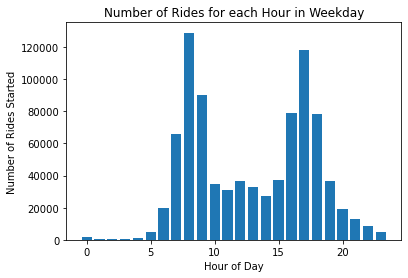

In [22]:
plt.bar(WeekdayHours["Start_Hour"], WeekdayHours["Number_of_Trips"])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides Started')
plt.title('Number of Rides for each Hour in Weekday')

When we look at the amount of trips per hour, we can see that there are some hours that have a much greater ridership. Thinking about our business, this would appear to indicate that these hours would have more commuters in general (especially since the most popular trip start hours are centered around what we consider traditional work hours), letting us narrow down our trips further (7-9 am, 4-6 pm).

#### This is SQL for the view WeekdayCommuteHours
```
SELECT
  *
FROM (
  SELECT
    *,
    EXTRACT(HOUR
    FROM
      start_date) AS Start_Hour,
    CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes
  FROM
    bike_trip_data.Weekday_Trips)
WHERE
  (Start_Hour > 6
    AND Start_Hour < 10)
  OR ((Start_Hour > 3
      AND Start_Hour < 7))
```

Next, we can realize that a commute would likely involve going from one station to another (returning to the original station would be more likely to be exercise or purely for enjoyment). With this, we can narrow down our dataset once more. Once we do that, we can think about another factor: the length of the trip. We can go ahead and look at some of the times that our trips took.

#### SQL for View WeekdayCrossStationTrips
```
SELECT
  *
FROM
    bike_trip_data.WeekdayCommuteHours
WHERE
  start_station_name <> end_station_name
```

In [32]:
! bq query --use_legacy_sql=FALSE --format=csv \
'SELECT\
  COUNT(*) AS Number_of_Trips,\
  CASE\
    WHEN duration_minutes < 5 THEN "Less than 5"\
    WHEN duration_minutes >= 5\
  AND duration_minutes < 15 THEN "Between 5 and 15"\
    WHEN duration_minutes >=15 AND duration_minutes < 30 THEN "Between 15 and 30"\
    WHEN duration_minutes >= 30\
  AND duration_minutes < 45 THEN "Between 30 and 45"\
    WHEN duration_minutes >=45 AND duration_minutes < 60 THEN "Between 45 and 60"\
    WHEN duration_minutes >= 60 THEN "More than 1 hour"\
END\
  AS Trip_Duration\
FROM (\
  SELECT\
    *\
  FROM (\
    SELECT\
      *\
    FROM (\
      SELECT\
        *,\
        EXTRACT(HOUR\
        FROM\
          start_date) AS Start_Hour,\
        CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes\
      FROM (\
        SELECT\
          *\
        FROM (\
          SELECT\
            *,\
            CASE EXTRACT(DAYOFWEEK\
            FROM\
              start_date)\
              WHEN 1 THEN "Sunday"\
              WHEN 2 THEN "Monday"\
              WHEN 3 THEN "Tuesday"\
              WHEN 4 THEN "Wednesday"\
              WHEN 5 THEN "Thursday"\
              WHEN 6 THEN "Friday"\
              WHEN 7 THEN "Saturday"\
          END\
            AS Day_of_Week,\
          FROM\
            `bigquery-public-data.san_francisco.bikeshare_trips`)\
        WHERE\
          Day_of_Week <> "Saturday"\
          AND DAY_of_Week <> "Sunday"))\
    WHERE\
      (Start_Hour > 6\
        AND Start_Hour < 10)\
      OR ((Start_Hour > 3\
          AND Start_Hour < 7)))\
  WHERE\
    start_station_name <> end_station_name)\
GROUP BY\
  Trip_Duration' > CommuteTripTime.csv

Waiting on bqjob_r42ddfa1341174be8_00000174d647f8a4_1 ... (1s) Current status: DONE   


In [33]:
triptime = pd.read_csv('CommuteTripTime.csv')

In [34]:
triptime

,Number_of_Trips,Trip_Duration
0,41929,Less than 5
1,235235,Between 5 and 15
2,28574,Between 15 and 30
3,795,Between 30 and 45
4,1382,More than 1 hour
5,285,Between 45 and 60


Text(0.5, 1.0, 'Number of Trips for given Duration')

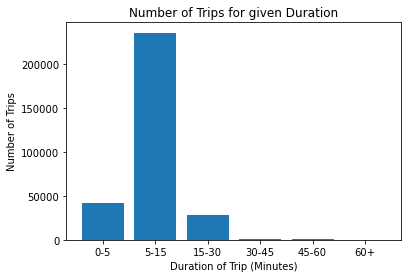

In [43]:
plt.bar(["0-5", "5-15", "15-30", "30-45", "45-60", "60+"], triptime["Number_of_Trips"])
plt.xlabel("Duration of Trip (Minutes)")
plt.ylabel("Number of Trips")
plt.title("Number of Trips for given Duration")

When we look at our results, we can see that the majority of our trips are less than 30 minutes. Since we are looking for the most popular commute trips, we can go ahead and limit our view to trips that took less than 30 minutes (since even if the other trips are commuters, it isn't the core ridership). We then need to investigate the trips that took less than 5 minutes. If we see a lot of 1 minute trips, we should be able to disregard those since they are likely input errors or mechanical failures.

In [39]:
! bq query --use_legacy_sql=FALSE --format=csv \
'SELECT\
  COUNT(*) AS Number_of_Trips,\
  CASE\
    WHEN duration_sec >= 0\
  AND duration_sec < 60 THEN "Between 0 and 1"\
    WHEN duration_sec >=60 AND duration_sec < 120 THEN "Between 1 and 2"\
    WHEN duration_sec >= 120\
  AND duration_sec < 180 THEN "Between 2 and 3"\
    WHEN duration_sec >=180 AND duration_sec < 240 THEN "Between 3 and 4"\
    WHEN duration_sec >= 240 AND duration_sec < 300 THEN "Between 4 and 5"\
    ELSE "5 or More Minutes"\
END\
  AS Trip_Duration\
FROM (\
  SELECT\
    *\
  FROM (\
    SELECT\
      *\
    FROM (\
      SELECT\
        *,\
        EXTRACT(HOUR\
        FROM\
          start_date) AS Start_Hour,\
        CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes\
      FROM (\
        SELECT\
          *\
        FROM (\
          SELECT\
            *,\
            CASE EXTRACT(DAYOFWEEK\
            FROM\
              start_date)\
              WHEN 1 THEN "Sunday"\
              WHEN 2 THEN "Monday"\
              WHEN 3 THEN "Tuesday"\
              WHEN 4 THEN "Wednesday"\
              WHEN 5 THEN "Thursday"\
              WHEN 6 THEN "Friday"\
              WHEN 7 THEN "Saturday"\
          END\
            AS Day_of_Week,\
          FROM\
            `bigquery-public-data.san_francisco.bikeshare_trips`)\
        WHERE\
          Day_of_Week <> "Saturday"\
          AND DAY_of_Week <> "Sunday"))\
    WHERE\
      (Start_Hour > 6\
        AND Start_Hour < 10)\
      OR ((Start_Hour > 3\
          AND Start_Hour < 7)))\
  WHERE\
    start_station_name <> end_station_name)\
GROUP BY\
  Trip_Duration' > CommuteTripTime.csv

Waiting on bqjob_r397825d5cfebb652_00000174d6578e90_1 ... (1s) Current status: DONE   


In [40]:
fivemintrip = pd.read_csv("CommuteTripTime.csv")

In [41]:
fivemintrip

,Number_of_Trips,Trip_Duration
0,20429,Between 3 and 4
1,25925,Between 4 and 5
2,252935,5 or More Minutes
3,7197,Between 2 and 3
4,1714,Between 1 and 2


When we look at the breakdown for the trips within 5 minutes, we can see that the majority are between 3 and 5 minutes. If we look at our station map, this is feasible since we can commute between many stations in around 3 minutes (some stations are less than a block to a couple of blocks apart in the city). For those less than 3 minutes, we can go ahead and exclude them. This lets use reduce down our trips once more.

#### SQL for View IncludeDuration
```
SELECT
  *
FROM
  bike_trip_data.WeekdayCrossStationTrips
WHERE
  duration_sec >= 180
  AND duration_minutes < 30
```

Finally, one more thing that we want to look at is the amount of subscriber trips versus customer trips. We would imagine that if these trips really are commuter trips, the individuals will likely be subscribers since the way membership works if you ride a bike more than once a week (there and back) it will be a better deal to join as a member than to pay for each ride individually.

In [44]:
! bq query --use_legacy_sql=FALSE --format=csv \
'SELECT Count(*) as Number_of_Trips,\
  subscriber_type\
FROM (SELECT\
  *\
FROM\
  (SELECT\
    *\
  FROM (\
    SELECT\
      *\
    FROM (\
      SELECT\
        *,\
        EXTRACT(HOUR\
        FROM\
          start_date) AS Start_Hour,\
        CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes\
      FROM (\
        SELECT\
          *\
        FROM (\
          SELECT\
            *,\
            CASE EXTRACT(DAYOFWEEK\
            FROM\
              start_date)\
              WHEN 1 THEN "Sunday"\
              WHEN 2 THEN "Monday"\
              WHEN 3 THEN "Tuesday"\
              WHEN 4 THEN "Wednesday"\
              WHEN 5 THEN "Thursday"\
              WHEN 6 THEN "Friday"\
              WHEN 7 THEN "Saturday"\
          END\
            AS Day_of_Week,\
          FROM\
            `bigquery-public-data.san_francisco.bikeshare_trips`)\
        WHERE\
          Day_of_Week <> "Saturday"\
          AND DAY_of_Week <> "Sunday"))\
    WHERE\
      (Start_Hour > 6\
        AND Start_Hour < 10)\
      OR ((Start_Hour > 3\
          AND Start_Hour < 7)))\
  WHERE\
    start_station_name <> end_station_name)\
WHERE\
  duration_sec >= 180\
  AND duration_minutes < 30)\
GROUP BY subscriber_type' > Subscriber.csv

Waiting on bqjob_r4c567fe614c5f332_00000174d6c82101_1 ... (1s) Current status: DONE   


In [45]:
subnum = pd.read_csv("Subscriber.csv")
subnum

,Number_of_Trips,subscriber_type
0,288259,Subscriber
1,8568,Customer


Text(0.5, 1.0, 'Number of Trips for each Subscriber Type')

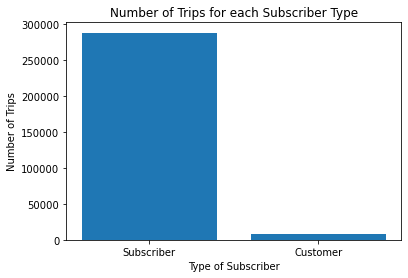

In [47]:
plt.bar(subnum["subscriber_type"], subnum["Number_of_Trips"])
plt.xlabel("Type of Subscriber")
plt.ylabel("Number of Trips")
plt.title("Number of Trips for each Subscriber Type")

We see that as we suspect, most of the trips taken during what we've determined to be commute times are from subscribers. We can then reduce our data to only subscriber trips.

#### SQL for view CommuteTrips
```
SELECT
  *
FROM
  bike_trip_data.IncludeDuration
WHERE
  subscriber_type = "Subscriber"
```

Now that we have our reduced database of "commuter trips", we need to determine the five most popular ones. To do this, we must consider how we want to define a trip. The way that I am going to determine the popularity of a trip is to find the total number of rides that go between the stations. This means that we will combine rides that start at Station A and end at Station B with the rides that start at Station B and end at Station A (we can't just look at one direction since there might be some factors around station at the other end of a commute that causes more or less ridership). Putting this into effect, we can get the following table.